# Projet de Monte Carlo : Méta-étude sur la prévalence de Listeria dans le lait cru

In [222]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import scipy.stats
from scipy.stats import betabinom, expon, uniform, norm, beta, binom
from statsmodels.graphics.tsaplots import plot_acf
from scipy.special import beta as betafun

path = '/Users/IcloudElliott/Desktop/ENSAE/2A/MonteCarlo/'
f = open(path + 'listeria.txt', "r")

lines = f.readlines()

On lit les données et les store dans une dataframe.

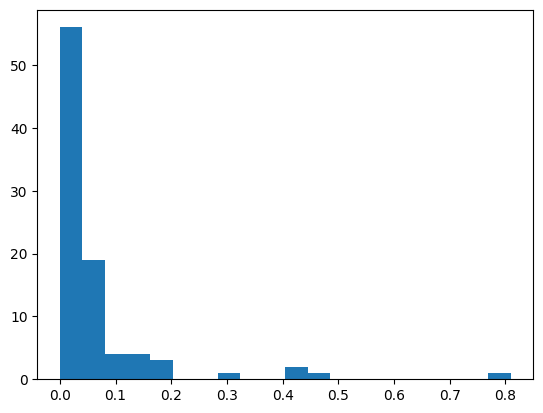

In [296]:
df = pd.DataFrame()
Ns = []
rs = []
for l in lines:
    spl = l.split(sep = ',')
    rs.append(int(spl[0]))
    Ns.append(int(spl[1]))

df['N'] = Ns
df['r'] = rs
df['p'] = [i/j for i,j in zip(rs,Ns)]
df.tail()
plt.hist(df['p'],bins = 20)
plt.show()

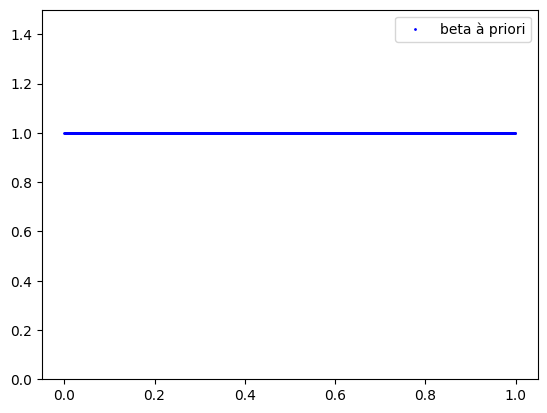

1257054

In [298]:
N = sum(df['N']) # nombre de tests
r = sum(df['r']) # nombre d'échantillons trouvés (succès)
p = r/N # taux de succès

a = 1
b = 1
fig, ax = plt.subplots(1, 1)

x = np.arange(0,1,.001)
ax.plot(x, beta.pdf(x, a, b), 'bo', ms=1, label='beta à priori')
ax.set_ylim(0,1.5)
plt.legend()
plt.show()

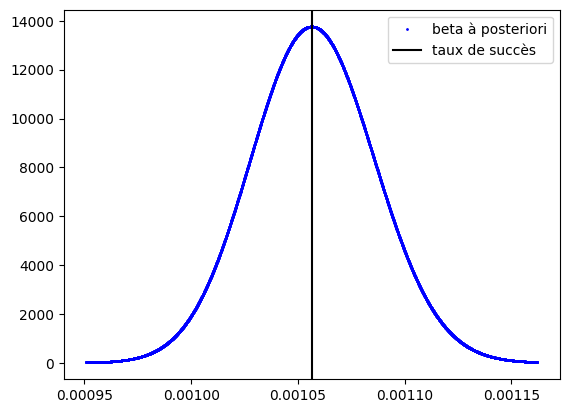

In [319]:
a_post = a + r # update le prior en ajoutant les positifs
b_post = b + N - r # et les négatifs

#print(a_post,b_post)
x = np.linspace(p-p/10,p+p/10,4000)
plt.plot(x, beta.pdf(x, a_post, b_post), 'bo', ms=1, label='beta à posteriori')
plt.axvline(p,c = 'black',label = 'taux de succès')
plt.legend()
plt.show()

In [325]:
def log_vrais_p(p,a,b): # log vraisemblance pour une observation
    l = (a-1)*np.log(p)+(b-1)*np.log(1-p)-np.log(betafun(a,b))-0.1*(a+b)
    return(l)

def log_vrais(P,a,b): #log vraisemblance de l'échantillon
    s = sum([log_vrais_p(p,a,b) for p in P])
    return(s)

def R_mu(P,mu,mu_new,kappa): # différence des log vraisemblances pour kappa
    a = mu*kappa
    b = kappa*(1-mu)
    a_new = mu_new*kappa
    b_new = kappa*(1-mu_new)
    r = log_vrais(P,a_new,b_new) - log_vrais(P,a,b)
    return(r)

def R_kappa(P,mu,kappa,kappa_new):
    a = mu*kappa
    b = kappa*(1-mu)
    a_new = mu*kappa_new
    b_new = kappa_new*(1-mu)
    r = log_vrais(P,a_new,b_new)  - log_vrais(P,a,b)
    return(r)

mu = scipy.stats.uniform().rvs()
kappa = scipy.stats.expon(0.1).rvs() # on initialise les coéfficients selon leurs distributions initiales
sigma_mu = .1 # tels que taux d'acceptation = 25%
sigma_kappa = .3
N = df['N']
P = list(df['p'])
starting_point = [mu, kappa] + P # On initialise le vecteur à simuler
def gibbs_sampler(starting_point, n_iter):
    n_accept_mu = 0
    n_accept_kappa = 0
    chain = [starting_point] # on conserve l'histoire entière de la chaine
    current_point = starting_point
 # on initialise a et b tels que mu = a/(a+b), kappa = a+b
 # mu est uniforme donc a et b suivent la même loi, a priori sans biais
    for i in range(n_iter):
        current_point = current_point.copy()
        mu = current_point[0]
        kappa = current_point[1]
        P = current_point[2:]
        
        mu_new = norm(mu,sigma_mu).rvs() # nouvelle proposition pour mu
        r = min(np.exp(R_mu(P,mu,mu_new,kappa)),1)
        if r > uniform().rvs(): #condition d'acceptation
            current_point[0] = mu_new
            n_accept_mu +=1
        
        kappa_new = norm(kappa,sigma_kappa).rvs()
        if kappa_new > 0:
            r = min(np.exp(R_kappa(P,mu,kappa,kappa_new)),1)
            if r > uniform().rvs():
                    current_point[1] = kappa_new
                    n_accept_kappa +=1
        
        a = mu*kappa
        b = kappa*(1-mu)
        
        for m in range(2,93): # on tire tous les p
            current_point[m] = beta(a,b).rvs()
        
        chain.append(current_point) #on enregistre cet état
    print("taux d'acceptation mu:",100*n_accept_mu/n_iter,"taux d'acceptation kappa:",100*n_accept_kappa/(n_iter))
    return np.array(chain),a,b

chain,a,b = gibbs_sampler(starting_point, 1000)

/Users/IcloudElliott/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/Users/IcloudElliott/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/IcloudElliott/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
/Users/IcloudElliott/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


taux d'acceptation mu: 21.7 taux d'acceptation kappa: 9.7


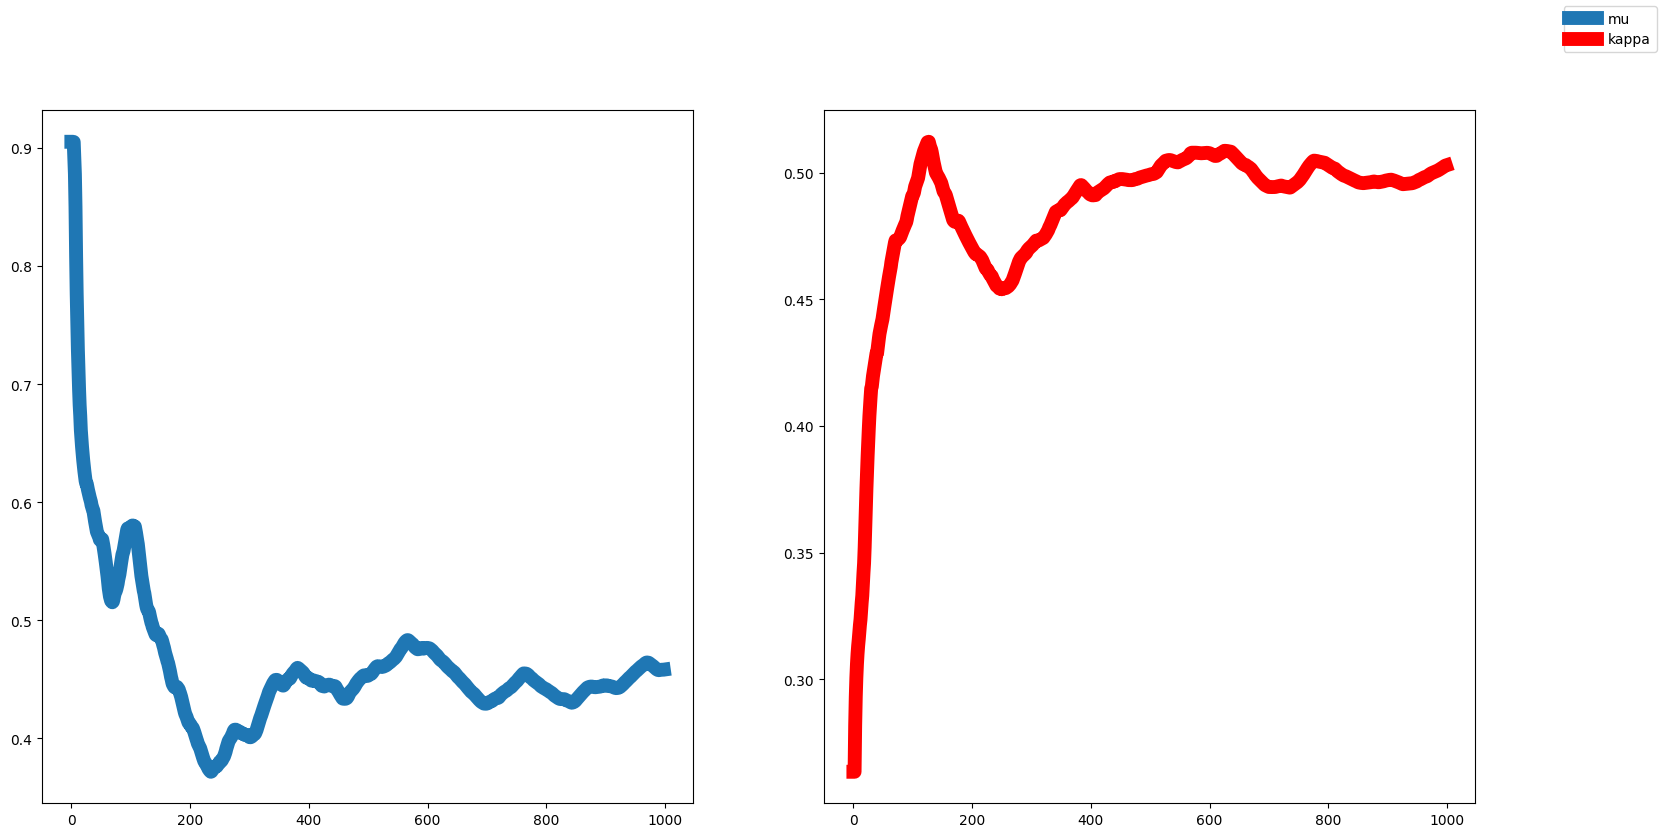

In [293]:
fig,axs = plt.subplots(1,2) #on affiche les évolutions des moyennes des mu et kappa et T
mus = chain[:,0]
kappas = chain[:,1]


axs[0].plot([sum(mus[:i])/i for i in range(1,1000)],label = 'mu',linewidth = 10)
axs[1].plot([sum(kappas[:i])/i for i in range(1,1000)],label = 'kappa', c = 'r',linewidth = 10)

fig.set_size_inches(18.5, 9)
fig.legend()
plt.show()

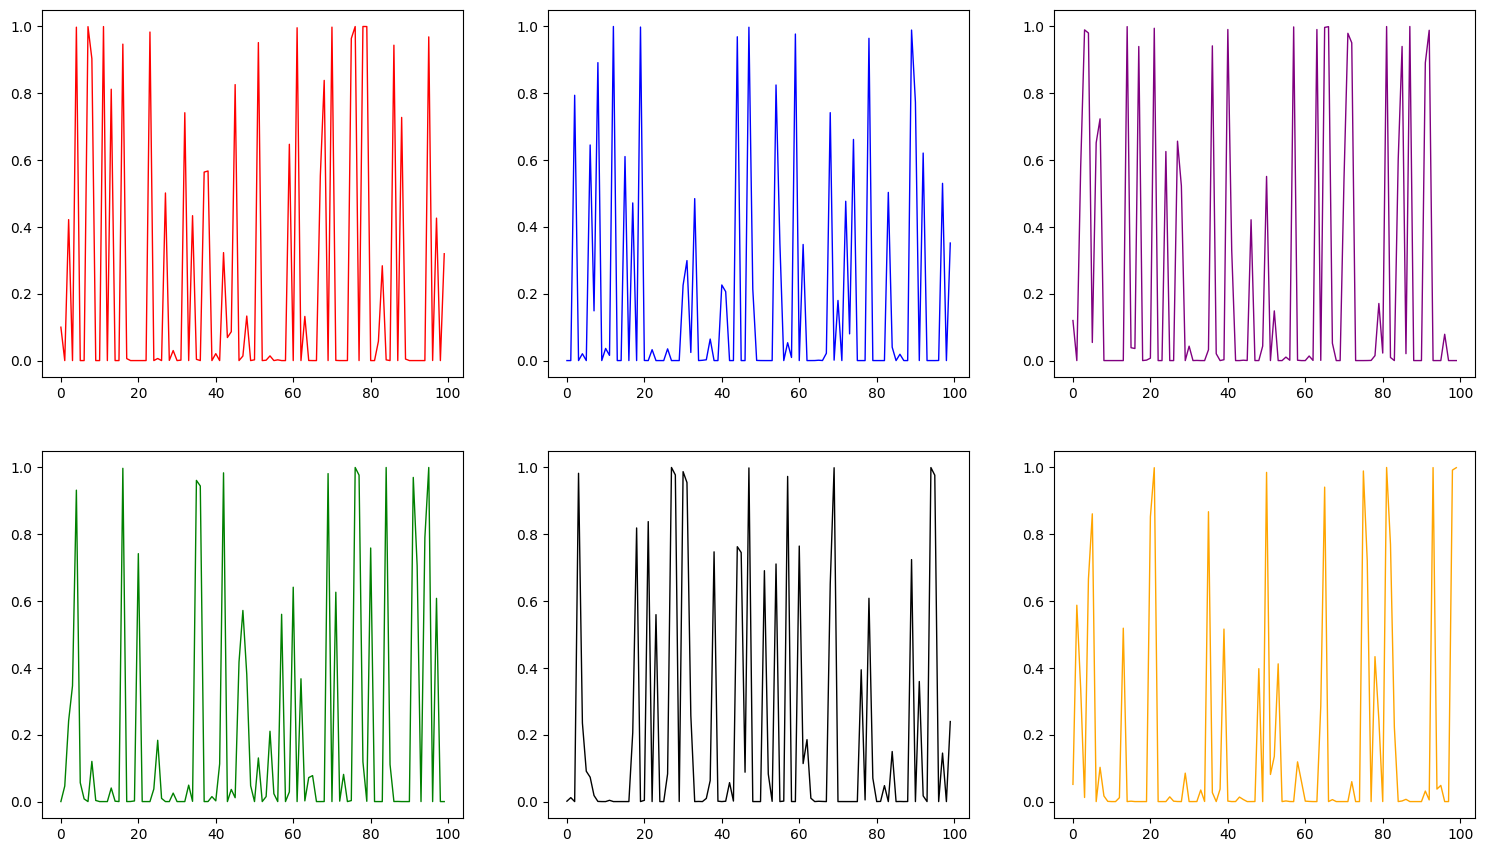

In [227]:
colors = ['red','green','blue','black','purple','orange']*4
first = 50
l,L = 2,3
fig,axs = plt.subplots(l,L)
first = 3
for i in range(l):
    for j in range(L):
        k = first + i + l*j
        axs[i][j].plot(chain[900:1000,k], c = colors[k - first],linewidth = 1)
fig.set_size_inches(18.5, 10.5)

plt.show() #derniers états pris par 6 p pris au milieu de la chaine

/Users/IcloudElliott/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:354: RuntimeWarning: Mean of empty slice.
  loc = data.mean()
/Users/IcloudElliott/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/IcloudElliott/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:359: RuntimeWarning: Mean of empty slice.
  scale = np.sqrt(((data - loc)**2).mean())


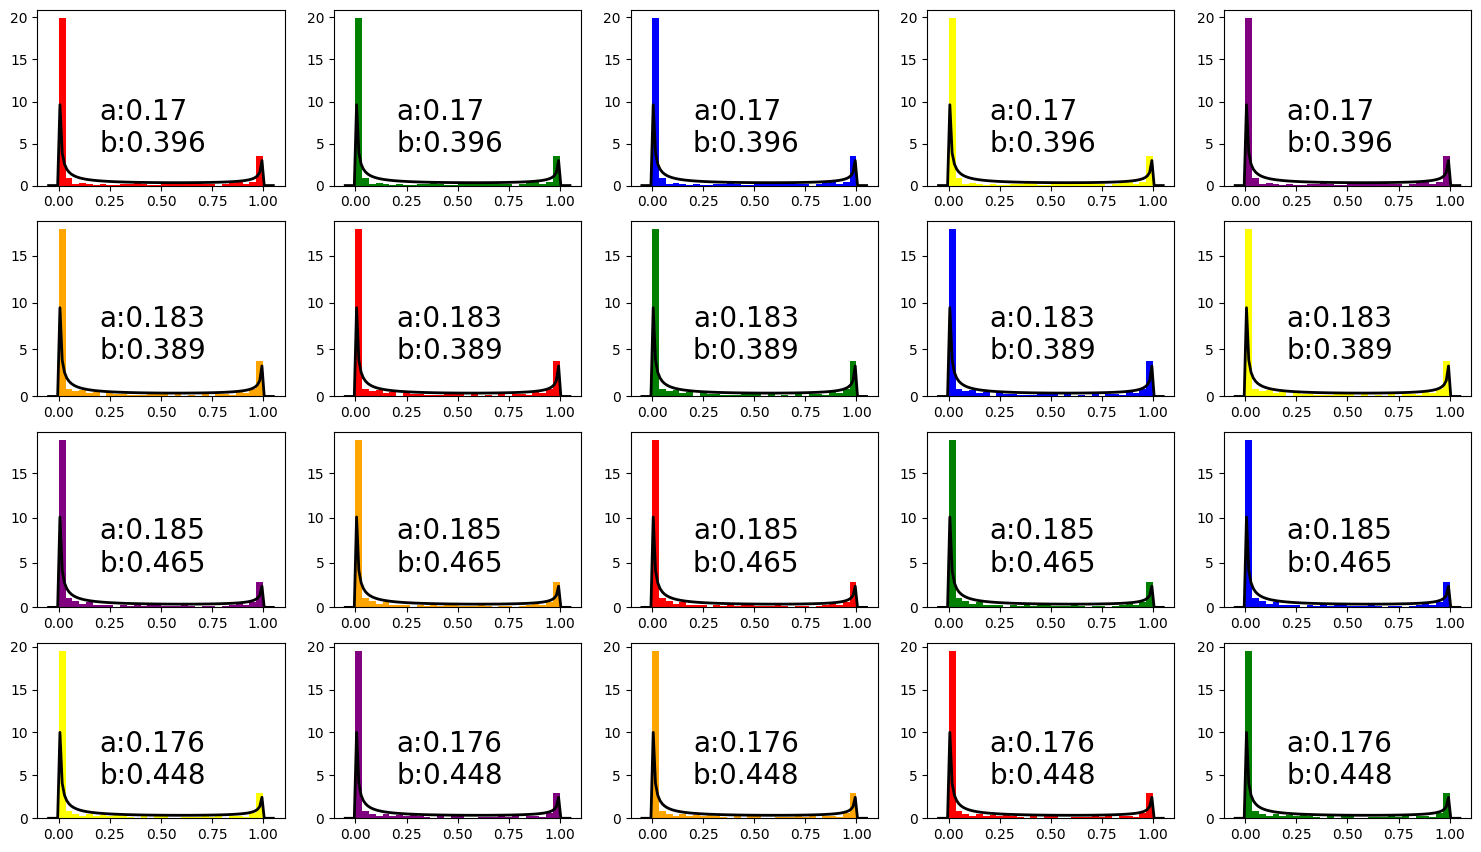

In [228]:
plt.style.use('default')


data = ps[500:]

# Fit a normal distribution to the data:
mu, std = norm.fit(data)

# Plot the histogram.

colors = ['red','green','blue','yellow','purple','orange']*4
first = 30
l,L = 4,5
fig,axs = plt.subplots(l,L)
first = 30
for i in range(l):
    for j in range(L):
        k = first + i + j*l
        axs[i][j].hist(chain[500:1000,k], bins=30, density=True, color = colors[i*L+j],label = k)

        a,b,l,s = beta.fit([.998*i+.001 for i in chain[500:1000,k]],floc = 0,fscale = 1)
#on fit a une loi beta
        xmin, xmax = axs[i][j].get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = beta.pdf(x, a, b)
        axs[i][j].plot(x, p, 'k', linewidth=2)
        axs[i][j].text(.2,4,f'a:{round(a,3)}\nb:{round(b,3)}',size = 20)
#on regarde que les 500 dernières valeurs pour éviter de fitter sur le burn in
for ax in axs.flat:

    for label in ax.get_yticklabels():
        label.set_fontsize(10)  

fig.set_size_inches(18.5, 10.5)
plt.show()
plt.show()

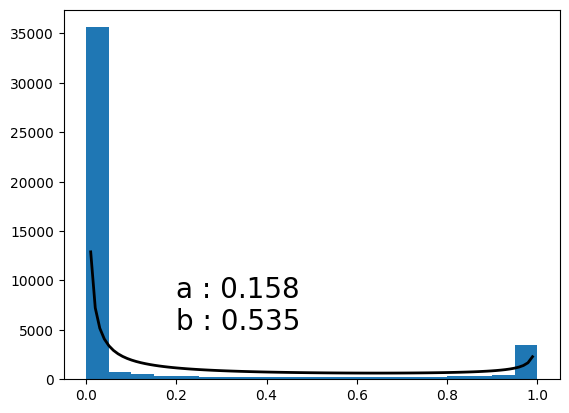

In [269]:
conc = np.concatenate([chain[500:,i] for i in range(2,91)])
plt.hist(conc,bins = 20)
a,b,l,s = beta.fit([.998*i+.001 for i in conc],floc = 0,fscale = 1)

x = np.linspace(0, 1, 100)
p = beta.pdf(x, a, b)
plt.plot(x, [2000*i for i in p], 'k', linewidth=2)
plt.text(.2,5000,f'a : {round(a,3)}\nb : {round(b,3)}',size = 20)
#on compare la distribution obtenue et son fit par une loi beta

plt.show()

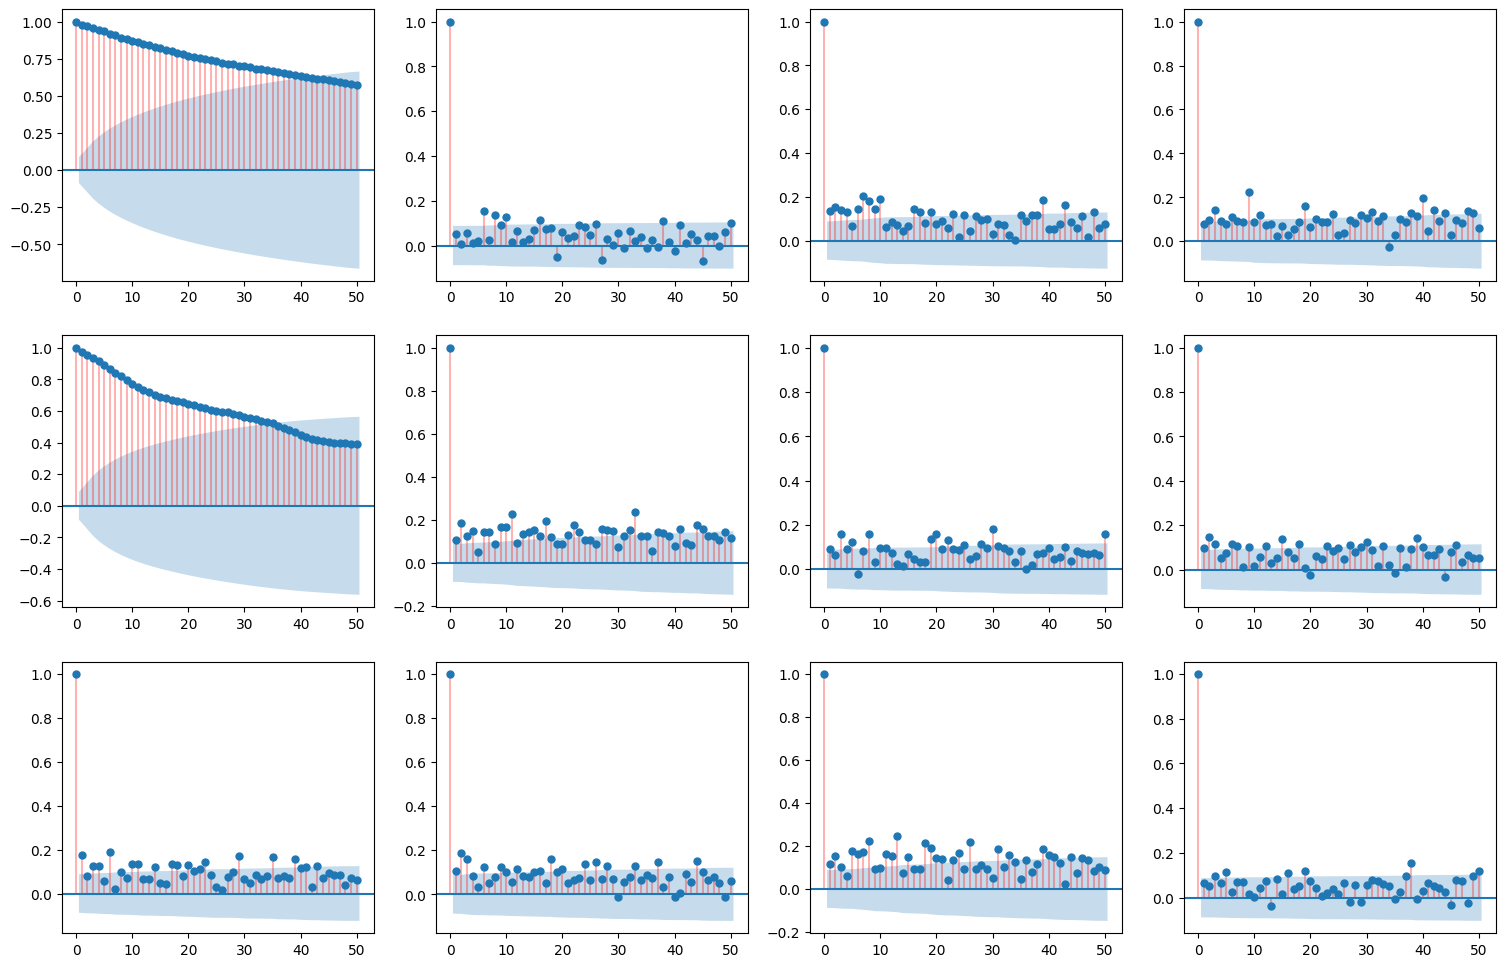

In [175]:
l,L = 3,4 #on affiche les 12 premières acf pour vérifier les autocorrélations
fig,axs = plt.subplots(l,L)
first = 0
for i in range(l):
    for j in range(L):
            k = first + i + l*j
            plot_acf(chain[500:,k],lags = 50,ax = axs[i,j],title = '',vlines_kwargs = {'color':'red','alpha':.3})
fig.set_size_inches(18.5, 12)

plt.show()

# BETA BETA

In [273]:
def betamix(p,a,b,c,d,T):
    betamix = T*(p**(a-1)*(1-p)**(b-1)/betafun(a,b))+(1-T)*(p**(c-1)*(1-p)**(d-1)/betafun(c,d))
    return betamix


def log_vrais_p_mix(p,a,b,c,d,T): # log vraisemblance pour une observation
    l = np.log(betamix(p,a,b,c,d,T))-0.1*(a+b+c+d)
    if np.isnan(l): # on rejette les valeurs abérrantes
        l=0
    return(l)

def log_vrais_mix(P,a,b,c,d,T): # log vraisemblance de l'échantillon
    s = sum([log_vrais_p_mix(p,a,b,c,d,T) for p in P])
    return(s)

def R_mu_1(P,mu_1,mu_2,mu_new,kappa_1,kappa_2,T): #différence des logV pour mu_1
    a = mu_1*kappa_1
    b = kappa_1*(1-mu_1)
    c = mu_2*kappa_2
    d = (1-mu_2)*kappa_2
    a_new = mu_new*kappa_1
    b_new = kappa_1*(1-mu_new)
    r = log_vrais_mix(P,a_new,b_new,c,d,T)-log_vrais_mix(P,a,b,c,d,T)
    return(r)

def R_mu_2(P,mu_1,mu_2,mu_new,kappa_1,kappa_2,T):
    a = mu_1*kappa_1
    b = kappa_1*(1-mu_1)
    c = mu_2*kappa_2
    d = (1-mu_2)*kappa_2
    c_new = mu_new*kappa_2
    d_new = kappa_2*(1-mu_new)
    r = log_vrais_mix(P,a,b,c_new,d_new,T)-log_vrais_mix(P,a,b,c,d,T)
    return(r)

def R_kappa_1(P,mu_1,mu_2,kappa_new,kappa_1,kappa_2,T):
    a = mu_1*kappa_1
    b = kappa_1*(1-mu_1)
    c = mu_2*kappa_2
    d = (1-mu_2)*kappa_2
    a_new = mu_1*kappa_new
    b_new = kappa_new*(1-mu_1)
    r =log_vrais_mix(P,a_new,b_new,c,d,T)-log_vrais_mix(P,a,b,c,d,T)
    return(r)

    
def R_kappa_2(P,mu_1,mu_2,kappa_new,kappa_1,kappa_2,T):
    a = mu_1*kappa_1
    b = kappa_1*(1-mu_1)
    c = mu_2*kappa_2
    d = (1-mu_2)*kappa_2
    c_new = mu_2*kappa_new
    d_new = kappa_new*(1-mu_2)
    r = log_vrais_mix(P,a,b,c_new,d_new,T)-log_vrais_mix(P,a,b,c,d,T)
    return(r)
  
def R_T(P,mu_1,mu_2,kappa_1,kappa_2,T,T_new): #on effectue également un pas de Metropolis pour T
    a = mu_1*kappa_1
    b = kappa_1*(1 - mu_1)
    c = mu_2*kappa_2
    d = (1 - mu_2)*kappa_2
    r = log_vrais_mix(P,a,b,c,d,T_new) - log_vrais_mix(P,a,b,c,d,T)
    return(r)

mu_1 = scipy.stats.uniform().rvs()
mu_2 = scipy.stats.uniform().rvs()
T = scipy.stats.uniform().rvs()
kappa_1 = scipy.stats.expon(0.1).rvs() # on initialise les coéfficients selon leurs distributions initiales
kappa_2 = scipy.stats.expon(0.1).rvs()
sigma_mu = .1 #pour que tous les taux d'acceptations soient vers .25
sigma_kappa = .3
sigma_tau = 0.1
P = list(df['p'])
starting_point = [mu_1,mu_2,kappa_1,kappa_2,T]+P # On initialise le vecteur à simuler
def gibbs_sampler(starting_point, n_iter):
    n_accept_mu_1 = 0
    n_accept_mu_2 = 0
    n_accept_kappa_1 = 0
    n_accept_kappa_2 = 0
    n_accept_T = 0 

    chain = [starting_point] # on conserve l'histoire entière de la chaine
    current_point = starting_point
    mu_1 = starting_point[0]
    mu_2 = starting_point[1]
    kappa_1 = starting_point[2]
    kappa_2 = starting_point[3]
    T = starting_point[4]
    a = kappa_1 * mu_1 # on initialise a,b,c,d tels que mu = a/(a+b), kappa = a+b
    b = kappa_1 * (1 - mu_1) # mu est uniforme donc a et b suivent la même loi, a priori sans biais
    c = kappa_2 * mu_2
    d = (1-mu_2)*kappa_2


    for i in range(n_iter):
        current_point = current_point.copy()
        P = current_point[5:]

        mu_new_1 = norm(mu_1,sigma_mu).rvs() #nouvelle proposition
        if mu_new_1 <= 1 and mu_new_1 >= 0: #on vérifie qu'elle est dans nos bornes, sinon rejet
            r = min(np.exp(R_mu_1(P,mu_1,mu_2,mu_new_1,kappa_1,kappa_2,T)),1)
            if r >uniform().rvs(): #condition d'acceptation
                current_point[0] = mu_new_1
                n_accept_mu_1 +=1

        mu_new_2 = norm(mu_2,sigma_mu).rvs()
        if mu_new_2 <= 1 and mu_new_2 >= 0:
            r = min(np.exp(R_mu_2(P,mu_1,mu_2,mu_new_2,kappa_1,kappa_2,T)),1)
            if r >uniform().rvs():
                current_point[1] = mu_new_2
                n_accept_mu_2 +=1

        kappa_new_1 = norm(kappa_1,sigma_kappa).rvs()
        if kappa_new_1 > 0:
            r = min(np.exp(R_kappa_1(P,mu_1,mu_2,kappa_new_1,kappa_1,kappa_2,T)),1)
            if r > uniform().rvs():
                current_point[2] = kappa_new_1
                n_accept_kappa_1 +=1
                kappa_new_1 = norm(kappa_1,sigma_kappa).rvs()

        kappa_new_2 = norm(kappa_2,sigma_kappa).rvs()          
        if kappa_new_2 > 0:
            r = min(np.exp(R_kappa_2(P,mu_1,mu_2,kappa_new_2,kappa_1,kappa_2,T)),1)
            if r > uniform().rvs():
                current_point[3] = kappa_new_2
                n_accept_kappa_2 +=1
        T_new = norm(T,sigma_tau).rvs() #Metropolis pour T aussi
        if T_new >= 0 and T <= 1 :
            r = min(np.exp(R_T(P,mu_1,mu_2,kappa_1,kappa_2,T,T_new)),1)
            if r > uniform().rvs():
                current_point[4] = T_new
                n_accept_T +=1

        mu_1 = current_point[0]
        mu_2 = current_point[1]
        kappa_1 = current_point[2]
        kappa_2 = current_point[3]
        T = current_point[4]

        a = kappa_1 * mu_1 
        b = kappa_1 * (1 - mu_1) 
        c = kappa_2 * mu_2
        d = (1-mu_2)*kappa_2

        for m in range(5,96):
            current_point[m] = T*beta(a,b).rvs() + (1-T)*beta(c,d).rvs()

        chain.append(current_point)
    print(a,b,c,d,T)
    print("taux d'acceptation mu_1:",100*n_accept_mu_1/n_iter,"taux d'acceptation kappa_1:",100*n_accept_kappa_1/(n_iter))
    print("taux d'acceptation mu_2:",100*n_accept_mu_2/n_iter,"taux d'acceptation kappa_2:",100*n_accept_kappa_2/(n_iter))
    print("taux d'acceptation T:",100*n_accept_T/n_iter)
    return np.array(chain)

chain = gibbs_sampler(starting_point, 1000)


/Users/IcloudElliott/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
/Users/IcloudElliott/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars
/Users/IcloudElliott/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/Users/IcloudElliott/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
/Users/IcloudElliott/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in double_scalars
/Users/IcloudElliott/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in double_scalars


0.06762072244087836 0.20650213744974377 0.7938280143337222 0.5647511474062237 0.009946203609095894
taux d'acceptation mu_1: 86.4 taux d'acceptation kappa_1: 36.8
taux d'acceptation mu_2: 36.5 taux d'acceptation kappa_2: 49.4
taux d'acceptation T: 16.3


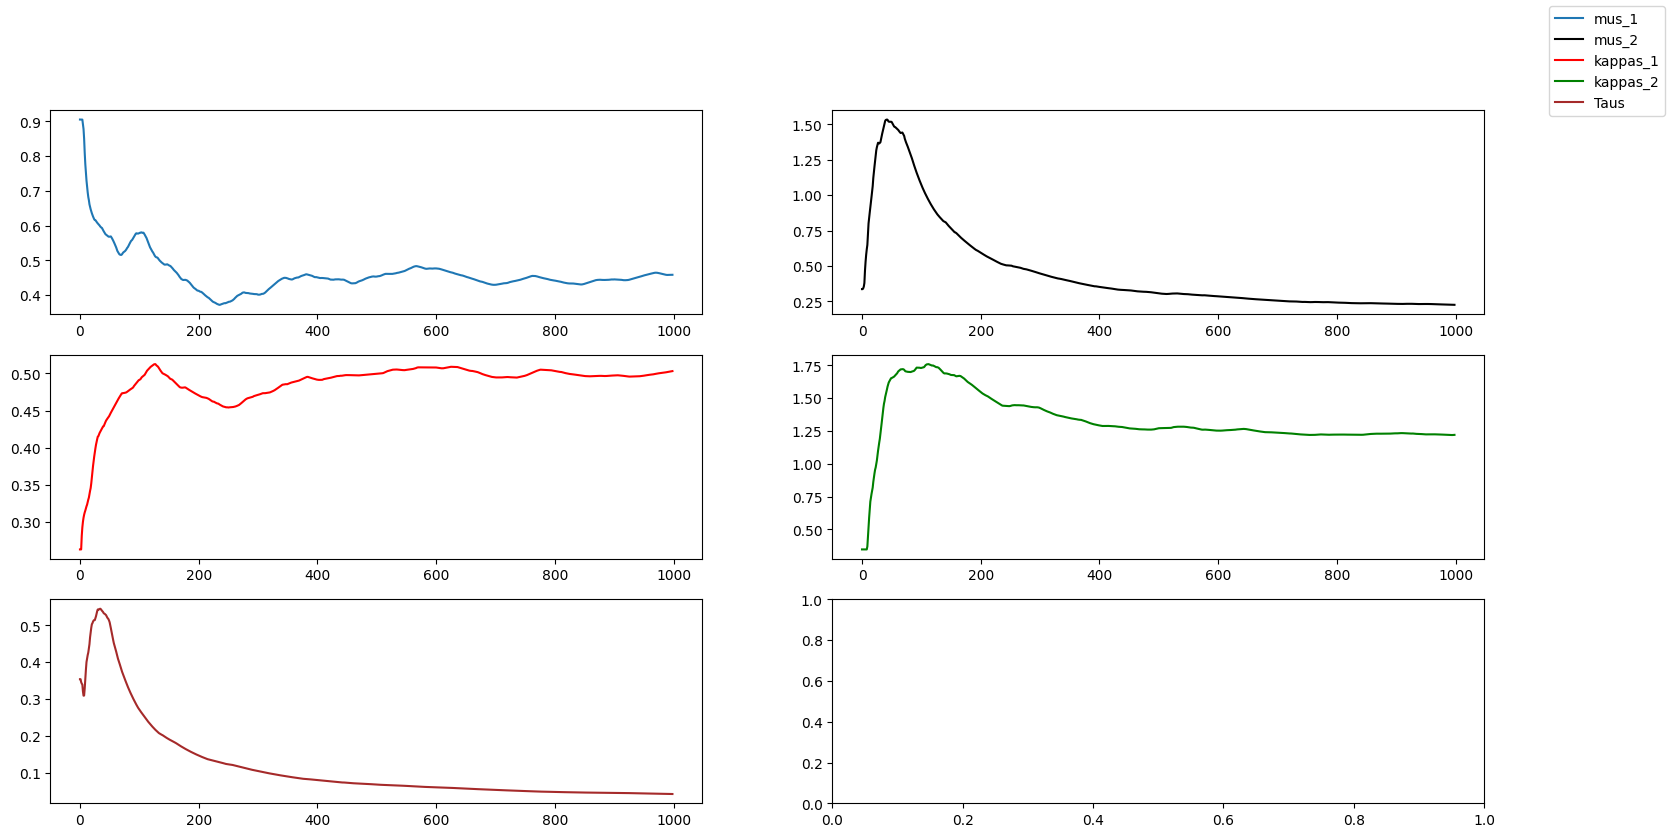

In [289]:
fig,axs = plt.subplots(3,2) #on affiche les évolutions des moyennes des mu et kappa et T
mu_1 = chain[:,0]
mu_2 = chain[:,1]
kappa_1 = chain[:,2]
kappa_2 = chain[:,3]
tau = chain[:,4]


axs[0][0].plot([sum(mu_1[:i])/i for i in range(1,1000)],label = 'mus_1')
axs[1][0].plot([sum(mu_2[:i])/i for i in range(1,1000)],label = 'kappas_1', c = 'r')
axs[0][1].plot([sum(kappa_1[:i])/i for i in range(1,1000)],label = 'mus_2',c = 'black')
axs[1][1].plot([sum(kappa_2[:i])/i for i in range(1,1000)],label = 'kappas_2',c = 'green')
axs[2][0].plot([sum(tau[:i])/i for i in range(1,1000)],label = 'Taus', c='brown')
fig.set_size_inches(18.5, 9)
fig.legend()
plt.show()

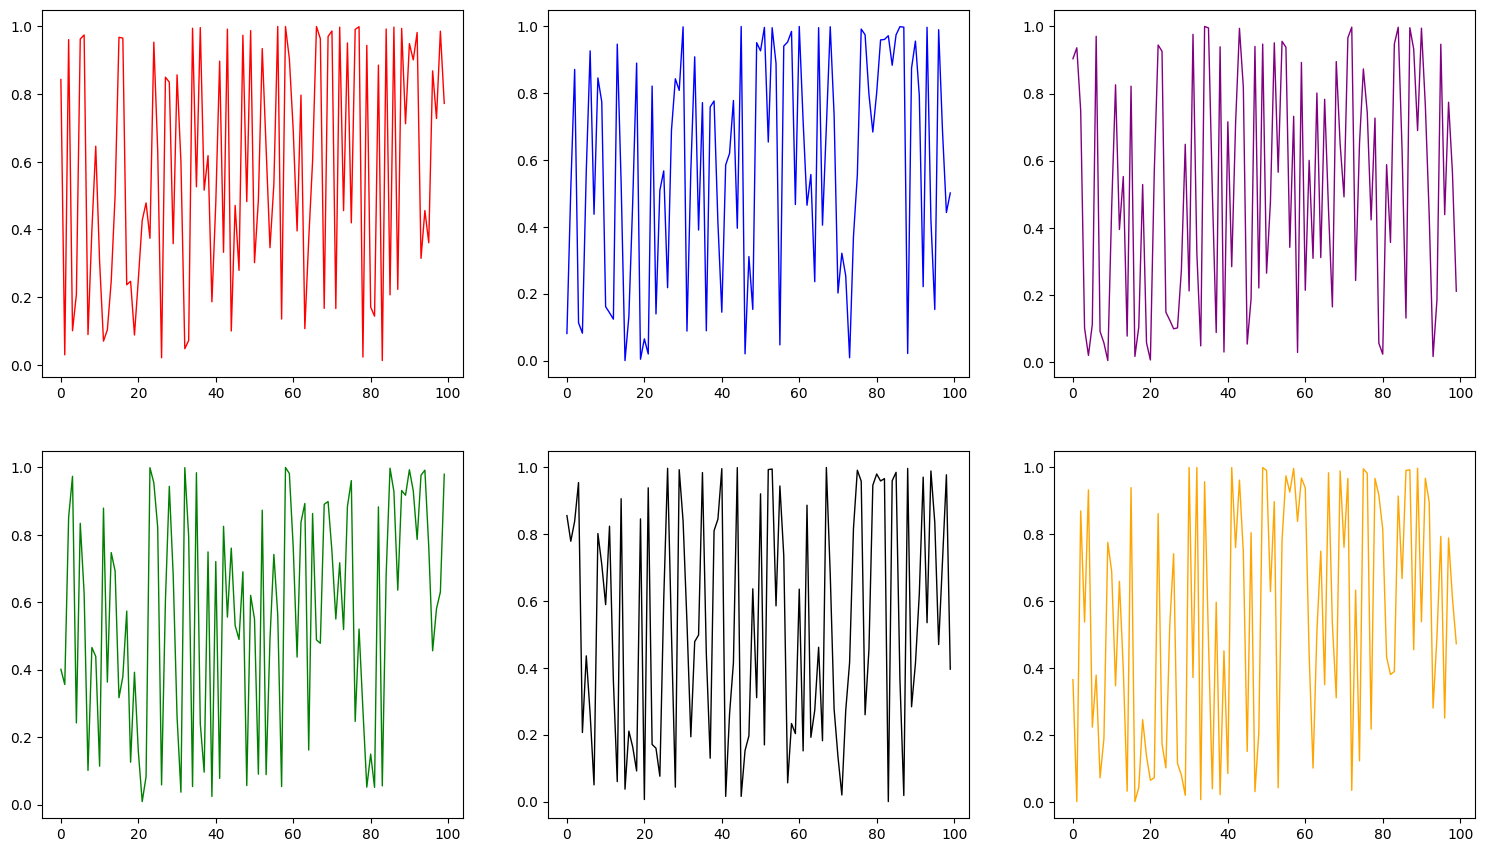

In [278]:
colors = ['red','green','blue','black','purple','orange']*4
first = 50
l,L = 2,3
fig,axs = plt.subplots(l,L)
first = 30
for i in range(l):
    for j in range(L):
        k = first + i + l*j
        axs[i][j].plot(chain[900:1000,k], c = colors[k - first],linewidth = 1)
fig.set_size_inches(18.5, 10.5)

plt.show() #derniers états pris par 6 p pris au milieu de la chaine

/Users/IcloudElliott/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:354: RuntimeWarning: Mean of empty slice.
  loc = data.mean()
/Users/IcloudElliott/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/IcloudElliott/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:359: RuntimeWarning: Mean of empty slice.
  scale = np.sqrt(((data - loc)**2).mean())


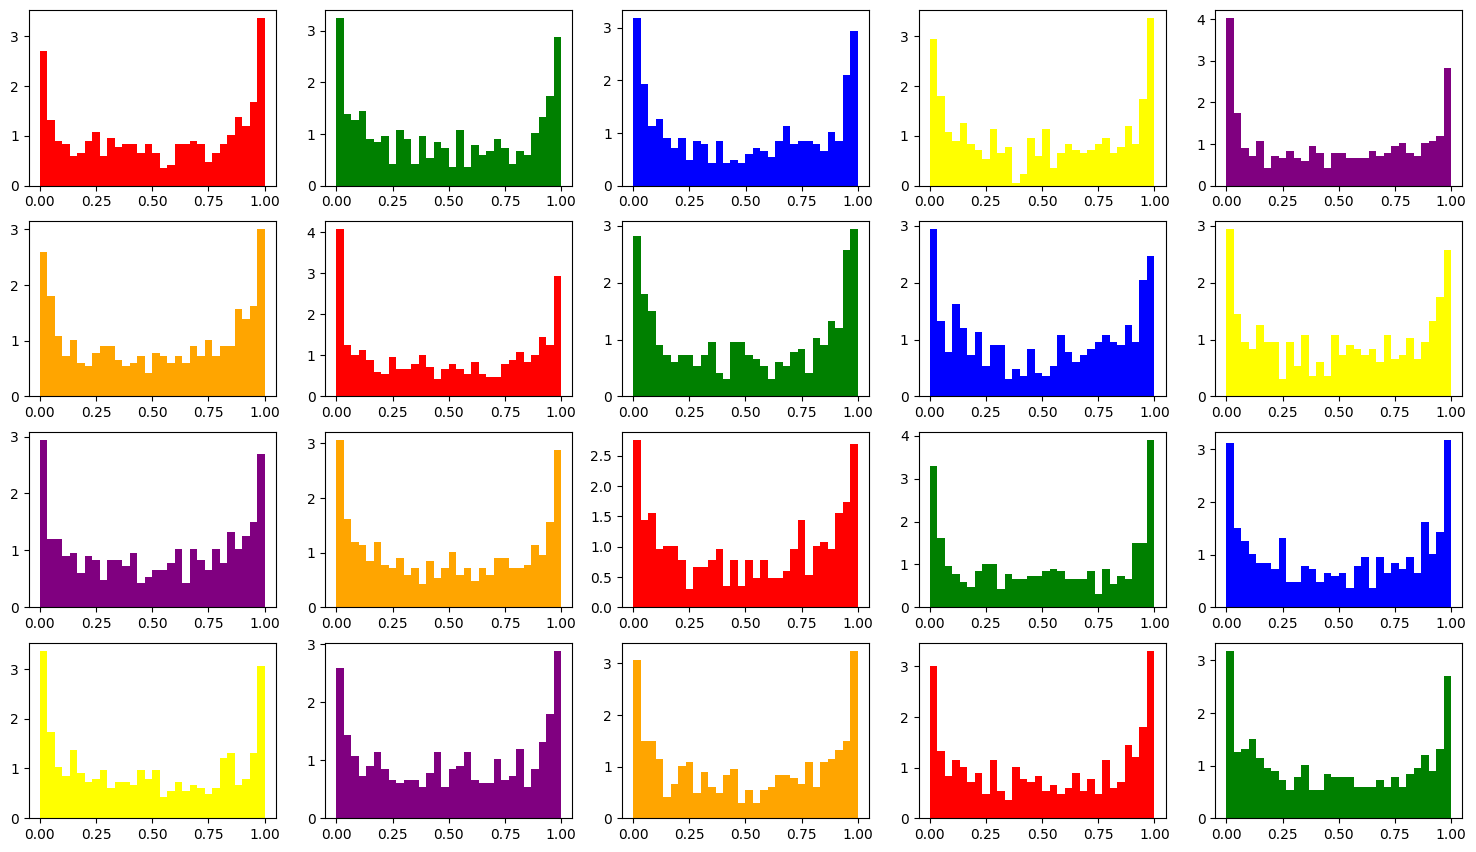

In [279]:
plt.style.use('default')


data = ps[500:]

# Fit a normal distribution to the data:
mu, std = norm.fit(data)

# Plot the histogram.

colors = ['red','green','blue','yellow','purple','orange']*4
first = 30
l,L = 4,5
fig,axs = plt.subplots(l,L)
first = 30
for i in range(l):
    for j in range(L):
        k = first + i + j*l
        axs[i][j].hist(chain[500:1000,k], bins=30, density=True, color = colors[i*L+j],label = k)
#on regarde que les 500 dernières valeurs pour éviter de fitter sur le burn in
for ax in axs.flat:

    for label in ax.get_yticklabels():
        label.set_fontsize(10)  

fig.set_size_inches(18.5, 10.5)
plt.show()
plt.show()

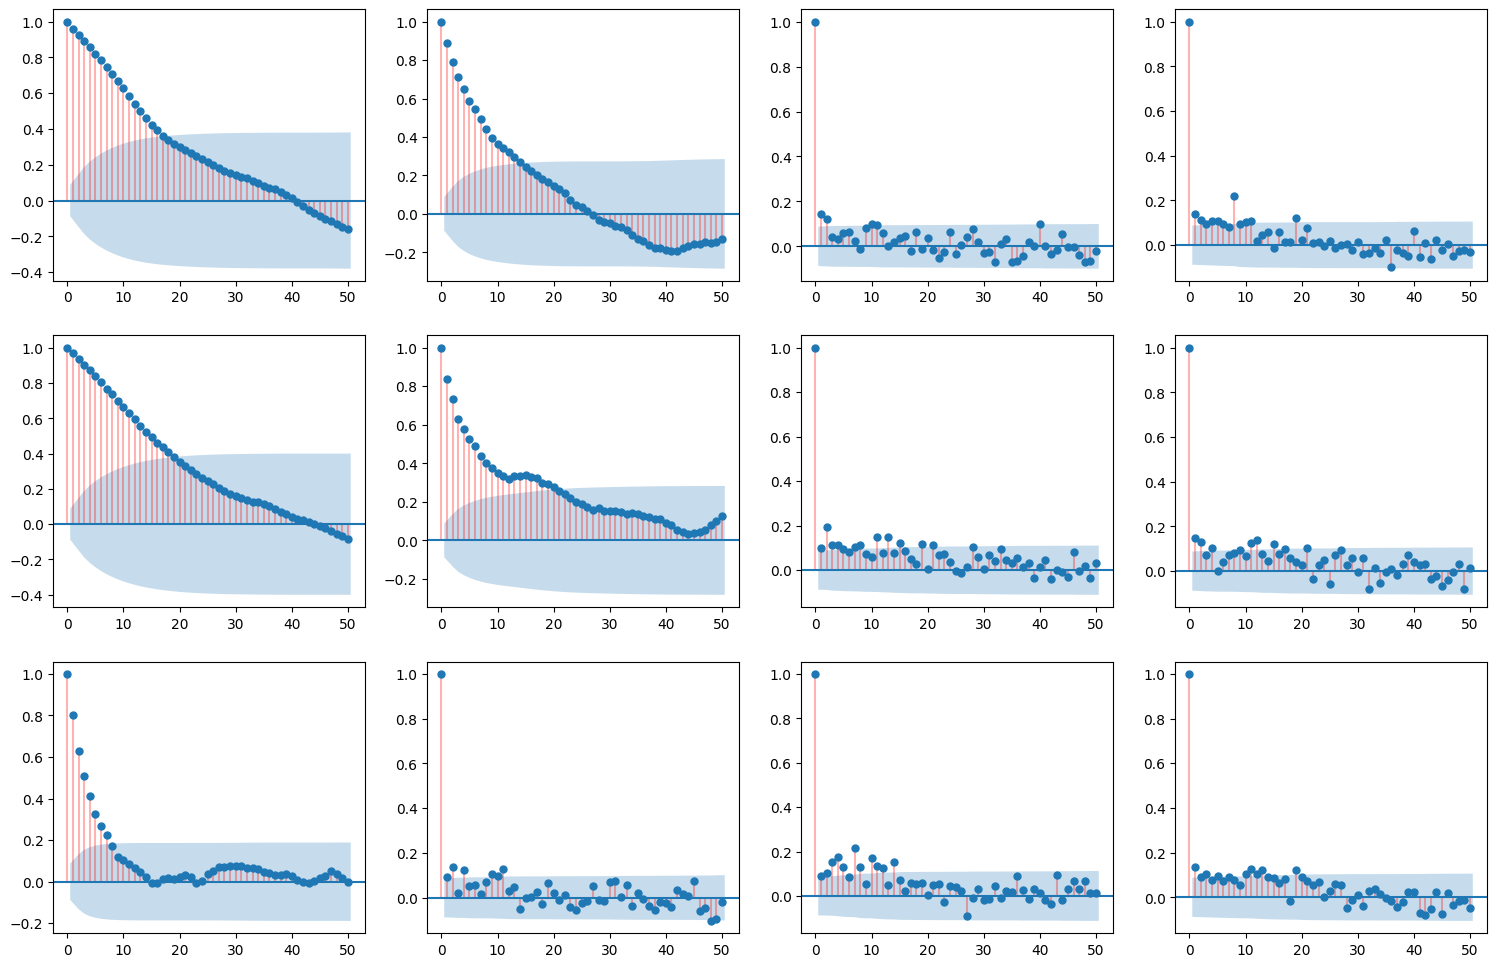

In [323]:
l,L = 3,4 #on affiche les 12 premières acf pour vérifier les autocorrélations
fig,axs = plt.subplots(l,L)
first = 0
for i in range(l):
    for j in range(L):
            k = first + i + l*j
            plot_acf(chain[500:,k],lags = 50,ax = axs[i,j],title = '',vlines_kwargs = {'color':'red','alpha':.3})
fig.set_size_inches(18.5, 12)

plt.show() #on voit que seules les 5 premiers ont des ordres d'autocorrélation hauts, à cause des acceptations rejets

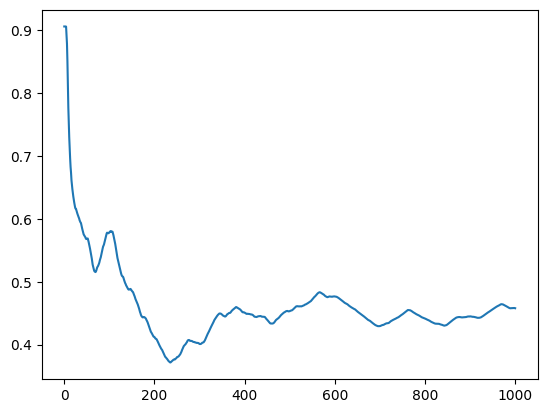

In [284]:
mus = chain[:,0]
moys = [sum(mus[:i])/(i+1) for i in range(len(mus))]
plt.plot(moys)
plt.show()